In [1]:
# Genetic Algorithm for Feature Selection using Log Loss (H/D/A prediction)
# - Reads features_all_seasons.csv
# - Derives H/D/A from home_goals vs away_goals
# - Uses LogisticRegression and log loss as GA fitness (lower is better)
# - Avoids leakage by excluding home_goals/away_goals from features
# - Saves GA history and best subset to /mnt/data/ga_feature_selection_outputs

In [2]:
import os
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


### Config


In [3]:


CSV_PATH = "../data/output/features_all_seasons.csv"  # change if needed


# Output folder
OUT_DIR = "/data/ga_feature_selection_outputs"

In [4]:
# GA hyperparameters
population_size = 100
generations = 30
crossover_rate = 0.8
mutation_rate = 0.05
tournament_size = 2
random_seed = 123


In [5]:
df = pd.read_csv(CSV_PATH)
df.head()


,fixture_id,date_utc,home_team_id,home_team,away_team_id,away_team,home_goals,away_goals,season,pre_xG_home,...,away_form_points,home_win_streak,away_win_streak,rest_days_home,rest_days_away,h2h_home_wins,h2h_away_wins,key_players_missing_home,key_players_missing_away,match_importance
0,862929,2022-07-30 16:00:00,40,Liverpool,50,Manchester City,3,1,2022,1.631179,...,12.0,NaN,NaN,NaN,NaN,0,0,0,0,1.2
1,867946,2022-08-05 19:00:00,52,Crystal Palace,42,Arsenal,0,2,2022,1.631179,...,1.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
2,867947,2022-08-06 11:30:00,36,Fulham,40,Liverpool,2,2,2022,1.631179,...,3.0,NaN,NaN,NaN,6.8125,0,0,0,0,1.0
3,867948,2022-08-06 14:00:00,35,Bournemouth,66,Aston Villa,2,0,2022,1.631179,...,1.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
4,867949,2022-08-06 14:00:00,63,Leeds,39,Wolves,2,1,2022,1.631179,...,0.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0


### Load & prepare data

In [6]:
# Derive H/D/A target from goals
def derive_result(row):
    if pd.isna(row["home_goals"]) or pd.isna(row["away_goals"]):
        return np.nan
    if row["home_goals"] > row["away_goals"]:
        return "H"
    elif row["home_goals"] < row["away_goals"]:
        return "A"
    else:
        return "D"


if "home_goals" not in df.columns or "away_goals" not in df.columns:
    raise ValueError(
        "CSV must contain 'home_goals' and 'away_goals' to derive H/D/A target."
    )

df["result_HDA"] = df.apply(derive_result, axis=1)
print("Result distribution:\n", df["result_HDA"].value_counts(dropna=False))

Result distribution:
 result_HDA
H    815
A    565
D    333
Name: count, dtype: int64


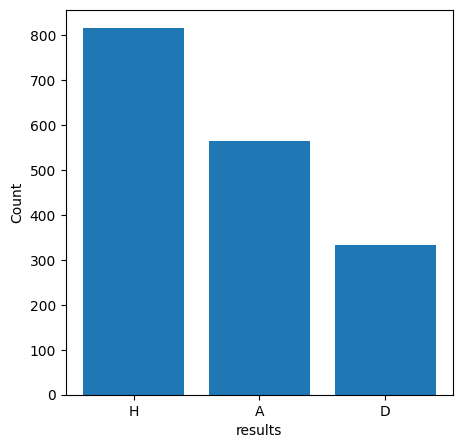

In [7]:
counts = df["result_HDA"].value_counts()

plt.figure(figsize=(5, 5))
plt.bar(counts.index, counts.values)
plt.xlabel('results')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'fixture_id'}>,
        <Axes: title={'center': 'home_team_id'}>,
        <Axes: title={'center': 'away_team_id'}>,
        <Axes: title={'center': 'home_goals'}>,
        <Axes: title={'center': 'away_goals'}>],
       [<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'pre_xG_home'}>,
        <Axes: title={'center': 'pre_xG_away'}>,
        <Axes: title={'center': 'home_xG_avg'}>,
        <Axes: title={'center': 'away_xG_avg'}>],
       [<Axes: title={'center': 'home_xGA_avg'}>,
        <Axes: title={'center': 'away_xGA_avg'}>,
        <Axes: title={'center': 'home_team_rating'}>,
        <Axes: title={'center': 'away_team_rating'}>,
        <Axes: title={'center': 'home_form_points'}>],
       [<Axes: title={'center': 'away_form_points'}>,
        <Axes: title={'center': 'home_win_streak'}>,
        <Axes: title={'center': 'away_win_streak'}>,
        <Axes: title={'center': 'rest_days_home'}>,
        <Axes: title={'center': 'rest_d

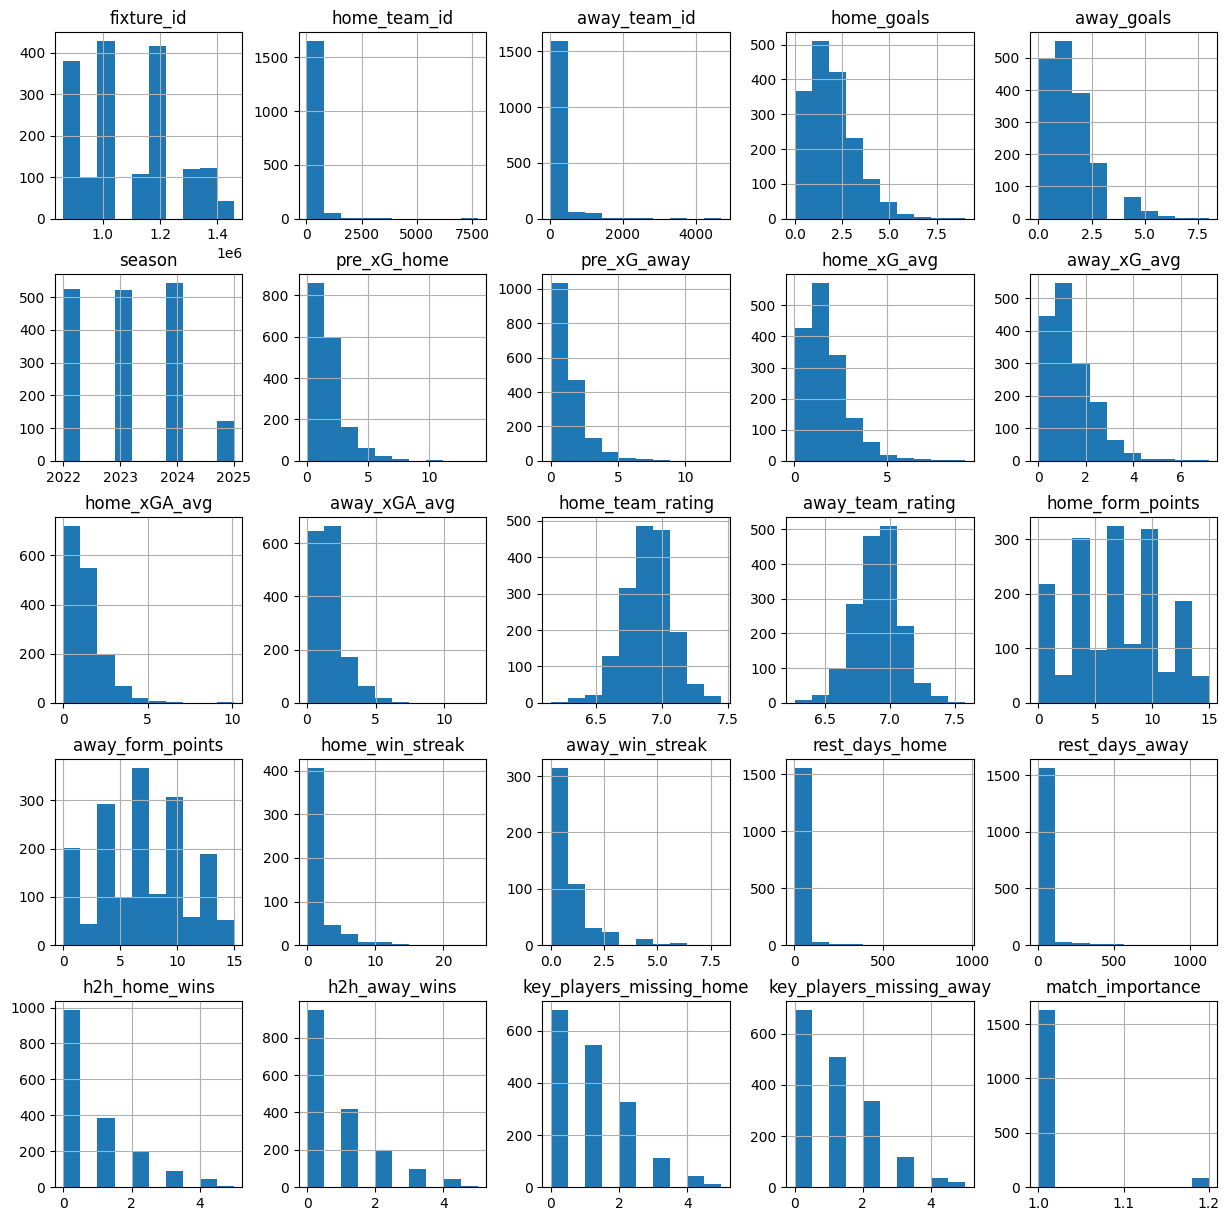

In [8]:
df.hist(figsize=(15, 15))

In [9]:
#20 first columns are deafault with none values 

# Candidate numeric features (exclude identifiers, team names, target, and leakage columns)
exclude_cols = {
    "fixture_id",
    "date_utc",
    "home_team_id",
    "away_team_id",
    "home_team",
    "away_team",
    "result_HDA",
    "home_goals",
    "away_goals",
}

numeric_candidates = [
    c
    for c in df.columns
    if pd.api.types.is_numeric_dtype(df[c]) and c not in exclude_cols
]


# Drop zero-variance/empty numeric columns
def non_constant_columns(frame: pd.DataFrame, cols: List[str]) -> List[str]:
    keep = []
    for c in cols:
        s = frame[c].dropna().values
        if len(s) == 0:
            continue
        if np.nanstd(s) == 0:
            continue
        keep.append(c)
        
    return keep

In [10]:
print(f"Candidate features before removing leakeg and so on: {len(df.columns)}")


Candidate features before removing leakeg and so on: 29


In [11]:
feature_candidates = non_constant_columns(df, numeric_candidates)
print(f"Candidate features after: {len(feature_candidates)}")
if len(feature_candidates) == 0:
    raise ValueError("No usable numeric features found after filtering.")

# Keep only rows with target
mask = df["result_HDA"].notna()
X = df.loc[mask, feature_candidates].copy()
y = df.loc[mask, "result_HDA"].astype(str)

# Fixed class order for consistent log_loss across folds
Y_CLASSES = np.array(sorted(y.unique()))

Candidate features after: 20


In [12]:
X.head()

,season,pre_xG_home,pre_xG_away,home_xG_avg,away_xG_avg,home_xGA_avg,away_xGA_avg,home_team_rating,away_team_rating,home_form_points,away_form_points,home_win_streak,away_win_streak,rest_days_home,rest_days_away,h2h_home_wins,h2h_away_wins,key_players_missing_home,key_players_missing_away,match_importance
0,2022,1.631179,1.222433,NaN,NaN,NaN,NaN,6.798393,6.911833,5.0,12.0,NaN,NaN,NaN,NaN,0,0,0,0,1.2
1,2022,1.631179,1.222433,NaN,NaN,NaN,NaN,6.933917,6.727667,11.0,1.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
2,2022,1.631179,1.222433,NaN,NaN,NaN,NaN,6.809500,6.887500,9.0,3.0,NaN,NaN,NaN,6.8125,0,0,0,0,1.0
3,2022,1.631179,1.222433,NaN,NaN,NaN,NaN,6.974051,6.717949,9.0,1.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
4,2022,1.631179,1.222433,NaN,NaN,NaN,NaN,6.653949,6.621429,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0


### Training and Fitness evaluation

In [13]:
def evaluate_subset_cv(
    cols: List[str], X_df: pd.DataFrame, y_series: pd.Series, n_splits: int = 5
) -> float:
    """Mean stratified K-fold log loss for a given subset of columns (lower is better)."""
    if len(cols) == 0:
        return 5.0  # penalty for empty subset

    X_vals = X_df[cols].values
    y_vals = y_series.values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    losses = []

    for tr_idx, va_idx in skf.split(X_vals, y_vals):
        X_tr, X_va = X_vals[tr_idx], X_vals[va_idx]
        y_tr, y_va = y_vals[tr_idx], y_vals[va_idx]

        try:
            pipe = Pipeline(
                steps=[
                    ("imp", SimpleImputer(strategy="median")),
                    ("sc", StandardScaler()),
                    (
                        "clf",
                        LogisticRegression(max_iter=1000),
                    ), 
                ]
            )

            pipe.fit(X_tr, y_tr)
            proba = pipe.predict_proba(X_va)

            # Reorder columns of proba to match Y_CLASSES for log_loss
            cls_order = pipe.named_steps["clf"].classes_
            aligned = np.zeros((proba.shape[0], len(Y_CLASSES)), dtype=float)
            for j, cls in enumerate(cls_order):
                aligned[:, np.where(Y_CLASSES == cls)[0][0]] = proba[:, j]

            fold_loss = log_loss(y_va, aligned, labels=Y_CLASSES)
        except Exception:
            fold_loss = 5.0  # penalize numerical/convergence issues

        losses.append(fold_loss)

    return float(np.mean(losses))


### Genetic Algorithm

In [14]:
def run_ga_experiment(
    population_size: int = 300,
    generations: int = 15,
    crossover_rate: float = 0.8,
    mutation_rate: float = 0.05,
    tournament_size: int = 2,
    random_seed: int = 123,
) -> dict:
    """
    Run one GA with given hyperparameters and return summary.
    This GA is self-contained (uses its own RNG and helpers).
    """
    rng = np.random.RandomState(random_seed)
    n_features_local = len(feature_candidates)

    # --- local helpers capturing rng & n_features_local ---
    def random_bits() -> np.ndarray:
        b = rng.randint(0, 2, size=n_features_local)
        if b.sum() == 0:
            b[rng.randint(0, n_features_local)] = 1
        return b

    def bits_to_cols_local(bits: np.ndarray) -> List[str]:
        return [feature_candidates[i] for i, v in enumerate(bits) if v == 1]

    def bits_key_local(bits: np.ndarray) -> str:
        return "".join(map(str, bits.tolist()))

    def tournament_select(pop: List[np.ndarray], fits: List[float]) -> np.ndarray:
        idxs = rng.choice(len(pop), size=tournament_size, replace=False)
        j = min(idxs, key=lambda i: fits[i])  # lower is better
        return pop[j].copy()

    def crossover(a: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if rng.rand() > crossover_rate or n_features_local < 2:
            return a.copy(), b.copy()
        p = rng.randint(1, n_features_local)
        c1 = np.concatenate([a[:p], b[p:]])
        c2 = np.concatenate([b[:p], a[p:]])
        # enforce at least one '1'
        if c1.sum() == 0:
            c1[rng.randint(0, n_features_local)] = 1
        if c2.sum() == 0:
            c2[rng.randint(0, n_features_local)] = 1
        return c1, c2

    def mutate(bits: np.ndarray) -> np.ndarray:
        for i in range(n_features_local):
            if rng.rand() < mutation_rate:
                bits[i] = 1 - bits[i]
        if bits.sum() == 0:
            bits[rng.randint(0, n_features_local)] = 1
        return bits

    # --- GA loop ---
    population = [random_bits() for _ in range(population_size)]
    fitness_cache: Dict[str, float] = {}
    history_rows = []

    best_bits = None
    best_ll = float("inf")
    prev_best_ll = float("inf")

    for g in range(generations):
        fitnesses = []
        new_evals = 0

        # Evaluate population
        for b in population:
            k = bits_key_local(b)
            if k in fitness_cache:
                ll = fitness_cache[k]
            else:
                cols = bits_to_cols_local(b)
                ll = evaluate_subset_cv(cols, X, y, n_splits=5)
                fitness_cache[k] = ll
                new_evals += 1
            fitnesses.append(ll)

        # Generation stats
        g_best_idx = int(np.argmin(fitnesses))
        g_best_bits = population[g_best_idx].copy()
        g_best_ll = float(fitnesses[g_best_idx])

        if g_best_ll < best_ll:
            best_ll = g_best_ll
            best_bits = g_best_bits.copy()

        improvement = prev_best_ll - g_best_ll if prev_best_ll != float("inf") else 0.0
        prev_best_ll = g_best_ll

        history_rows.append(
            {
                "generation": g,
                "best_log_loss": g_best_ll,
                "mean_log_loss": float(np.mean(fitnesses)),
                "median_log_loss": float(np.median(fitnesses)),
                "best_feature_count": int(g_best_bits.sum()),
            }
        )

        # You can comment this print if you want it quieter
        print(
            f"GA gen {g+1}/{generations} | "
            f"new_evals={new_evals}, "
            f"best_ll={g_best_ll:.4f}, "
            f"mean_ll={np.mean(fitnesses):.4f}, "
            f"best_feats={int(g_best_bits.sum())}, "
            f"improvement={improvement:+.4f}"
        )

        # Next generation (elitism)
        next_pop = [g_best_bits.copy()]
        while len(next_pop) < population_size:
            p1 = tournament_select(population, fitnesses)
            p2 = tournament_select(population, fitnesses)
            c1, c2 = crossover(p1, p2)

            c1 = mutate(c1)
            next_pop.append(c1)

            if len(next_pop) < population_size:
                c2 = mutate(c2)
                next_pop.append(c2)

        population = next_pop

    best_features = bits_to_cols_local(best_bits)
    result = {
        "best_log_loss": best_ll,
        "n_features_selected": int(best_bits.sum()),
        "best_features": best_features,
        "history": history_rows,
        "population_size": population_size,
        "generations": generations,
        "crossover_rate": crossover_rate,
        "mutation_rate": mutation_rate,
        "tournament_size": tournament_size,
        "random_seed": random_seed,
    }
    return result

### Matplot


In [15]:
ga_experiments = [
    {"population_size": 200, "generations": 10, "crossover_rate": 0.7, "mutation_rate": 0.03},
    {"population_size": 200, "generations": 10, "crossover_rate": 0.9, "mutation_rate": 0.03},
    {"population_size": 300, "generations": 15, "crossover_rate": 0.8, "mutation_rate": 0.05},
    {"population_size": 500, "generations": 20, "crossover_rate": 0.8, "mutation_rate": 0.10},
]

ga_results = []
ga_histories = []  # store history for each run if you want to inspect later

for i, cfg in enumerate(ga_experiments):
    print("=" * 70)
    print(f"Running GA experiment {i+1}/{len(ga_experiments)} with config: {cfg}")
    res = run_ga_experiment(
        population_size=cfg["population_size"],
        generations=cfg["generations"],
        crossover_rate=cfg["crossover_rate"],
        mutation_rate=cfg["mutation_rate"],
        tournament_size=2,
        random_seed=123 + i,  # different seeds for robustness
    )

    ga_results.append({
        **cfg,
        "best_log_loss": res["best_log_loss"],
        "n_features_selected": res["n_features_selected"],
        "res": res,  # store full result
    })
    ga_histories.append(res["history"])

ga_results_df = pd.DataFrame(ga_results).sort_values("best_log_loss")
print("\nGA tuning results (sorted by best_log_loss):")
print(ga_results_df)

best_ga_entry = min(ga_results, key=lambda d: d["best_log_loss"])
best_ga_res = best_ga_entry["res"]



Running GA experiment 1/4 with config: {'population_size': 200, 'generations': 10, 'crossover_rate': 0.7, 'mutation_rate': 0.03}
GA gen 1/10 | new_evals=200, best_ll=0.9629, mean_ll=0.9811, best_feats=10, improvement=+0.0000
GA gen 2/10 | new_evals=152, best_ll=0.9629, mean_ll=0.9750, best_feats=10, improvement=+0.0000
GA gen 3/10 | new_evals=152, best_ll=0.9626, mean_ll=0.9705, best_feats=8, improvement=+0.0003
GA gen 4/10 | new_evals=151, best_ll=0.9624, mean_ll=0.9687, best_feats=8, improvement=+0.0002
GA gen 5/10 | new_evals=152, best_ll=0.9624, mean_ll=0.9672, best_feats=8, improvement=+0.0000
GA gen 6/10 | new_evals=157, best_ll=0.9619, mean_ll=0.9666, best_feats=6, improvement=+0.0005
GA gen 7/10 | new_evals=124, best_ll=0.9619, mean_ll=0.9653, best_feats=6, improvement=+0.0000
GA gen 8/10 | new_evals=140, best_ll=0.9618, mean_ll=0.9656, best_feats=7, improvement=+0.0001
GA gen 9/10 | new_evals=120, best_ll=0.9616, mean_ll=0.9647, best_feats=5, improvement=+0.0002
GA gen 10/10 |

### PSO

In [16]:
def run_pso_experiment(
    swarm_size: int = 1000,
    iterations: int = 20,
    w_start: float = 0.9,
    w_end: float = 0.5,
    c_cognitive: float = 1.49,
    c_social: float = 1.49,
    v_max: float = 4.0,
    patience: int = 100,
    random_seed: int = 123,
) -> dict:
    """
    Run one PSO with given hyperparameters and return summary.
    """
    rng = np.random.RandomState(random_seed)
    n_features_local = len(feature_candidates)

    def bits_to_cols(bits: np.ndarray) -> List[str]:
        return [feature_candidates[i] for i, v in enumerate(bits) if v == 1]

    def bits_key(bits: np.ndarray) -> str:
        return "".join(map(str, bits.tolist()))

    def ensure_at_least_one(bits: np.ndarray) -> None:
        if bits.sum() == 0:
            bits[rng.randint(0, n_features_local)] = 1

    def sigmoid(z: np.ndarray) -> np.ndarray:
        z = np.clip(z, -20.0, 20.0)
        return 1.0 / (1.0 + np.exp(-z))

    # Initialization
    positions = (rng.rand(swarm_size, n_features_local) < 0.5).astype(np.int8)
    for i in range(swarm_size):
        ensure_at_least_one(positions[i])

    velocities = np.zeros((swarm_size, n_features_local), dtype=np.float32)
    pbest_pos = positions.copy()
    pbest_fit = np.full(swarm_size, np.inf)
    gbest_pos = None
    gbest_fit = np.inf
    fitness_cache_pso: Dict[str, float] = {}
    best_seen_iter = -1

    pso_history = []

    def evaluate_bits(bits: np.ndarray) -> float:
        k = bits_key(bits)
        if k in fitness_cache_pso:
            return fitness_cache_pso[k]
        cols = bits_to_cols(bits)
        if len(cols) == 0:
            ll = 10.0  # penalty
        else:
            ll = evaluate_subset_cv(cols, X, y, n_splits=5)
        fitness_cache_pso[k] = ll
        return ll

    # Main PSO loop
    for it in range(iterations):
        # Inertia scheduling
        t = it / (iterations - 1) if iterations > 1 else 0.0
        w = w_start * (1 - t) + w_end * t

        new_evals = 0
        fits = np.empty(swarm_size)

        # Evaluate particles
        for i in range(swarm_size):
            f = evaluate_bits(positions[i])
            fits[i] = f
            if f < pbest_fit[i]:
                pbest_fit[i] = f
                pbest_pos[i] = positions[i].copy()
            new_evals += 1

        # Global best update
        it_best_idx = int(np.argmin(fits))
        it_best_fit = float(fits[it_best_idx])
        it_best_pos = positions[it_best_idx].copy()

        if it_best_fit < gbest_fit or gbest_pos is None:
            gbest_fit = it_best_fit
            gbest_pos = it_best_pos.copy()
            best_seen_iter = it

        # Store history
        pso_history.append({
            "iteration": it,
            "iter_best_log_loss": it_best_fit,
            "mean_log_loss": float(np.mean(fits)),
            "median_log_loss": float(np.median(fits)),
            "global_best_log_loss": float(gbest_fit),
            "global_best_feature_count": int(gbest_pos.sum()),
        })

        print("=" * 60)
        print(f" Iteration {it+1}/{iterations}")
        print(f" New evaluations: {new_evals}")
        print(f" Iter best log loss: {it_best_fit:.4f}")
        print(f" Global best log loss: {gbest_fit:.4f}")
        print(f" Mean log loss: {np.mean(fits):.4f}")
        print(f" Unique feature sets: {len(fitness_cache_pso)}")

        # Early stopping
        if it - best_seen_iter >= patience:
            print(f"Early stopping at iteration {it} (no improvement for {patience} iterations).")
            break

        # Velocity & Position updates
        r1 = rng.rand(swarm_size, n_features_local)
        r2 = rng.rand(swarm_size, n_features_local)

        diff_pbest = pbest_pos - positions
        diff_gbest = gbest_pos - positions

        velocities = (w * velocities
                      + c_cognitive * r1 * diff_pbest
                      + c_social * r2 * diff_gbest)

        np.clip(velocities, -v_max, v_max, out=velocities)
        prob_one = sigmoid(velocities)
        positions = (rng.rand(swarm_size, n_features_local) < prob_one).astype(np.int8)

        for i in range(swarm_size):
            ensure_at_least_one(positions[i])

    best_features = bits_to_cols(gbest_pos)
    result = {
        "best_log_loss": gbest_fit,
        "n_features_selected": int(gbest_pos.sum()),
        "best_features": best_features,
        "history": pso_history,
        "swarm_size": swarm_size,
        "iterations": iterations,
        "w_start": w_start,
        "w_end": w_end,
        "c_cognitive": c_cognitive,
        "c_social": c_social,
        "v_max": v_max,
        "patience": patience,
        "random_seed": random_seed,
    }
    return result

In [17]:
pso_experiments = [
    {"swarm_size": 300, "iterations": 15, "w_start": 0.9, "w_end": 0.5},
    {"swarm_size": 300, "iterations": 15, "w_start": 0.7, "w_end": 0.3},
    {"swarm_size": 500, "iterations": 20, "w_start": 0.9, "w_end": 0.5},
]

pso_results = []

for i, cfg in enumerate(pso_experiments):
    print("=" * 70)
    print(f"Running PSO experiment {i+1}/{len(pso_experiments)} with config: {cfg}")
    res = run_pso_experiment(
        swarm_size=cfg["swarm_size"],
        iterations=cfg["iterations"],
        w_start=cfg["w_start"],
        w_end=cfg["w_end"],
        c_cognitive=1.49,
        c_social=1.49,
        v_max=4.0,
        patience=50,
        random_seed=321 + i,
    )

    pso_results.append({
        **cfg,
        "best_log_loss": res["best_log_loss"],
        "n_features_selected": res["n_features_selected"],
        "res": res,   # 👈 store the full PSO result here
    })

pso_results_df = pd.DataFrame(pso_results).sort_values("best_log_loss")
print("\nPSO tuning results (sorted by best_log_loss):")
print(pso_results_df)

best_pso_entry = min(pso_results, key=lambda d: d["best_log_loss"])
best_pso_res = best_pso_entry["res"]

Running PSO experiment 1/3 with config: {'swarm_size': 300, 'iterations': 15, 'w_start': 0.9, 'w_end': 0.5}
 Iteration 1/15
 New evaluations: 300
 Iter best log loss: 0.9644
 Global best log loss: 0.9644
 Mean log loss: 0.9819
 Unique feature sets: 300
 Iteration 2/15
 New evaluations: 300
 Iter best log loss: 0.9632
 Global best log loss: 0.9632
 Mean log loss: 0.9800
 Unique feature sets: 600
 Iteration 3/15
 New evaluations: 300
 Iter best log loss: 0.9630
 Global best log loss: 0.9630
 Mean log loss: 0.9770
 Unique feature sets: 900
 Iteration 4/15
 New evaluations: 300
 Iter best log loss: 0.9623
 Global best log loss: 0.9623
 Mean log loss: 0.9757
 Unique feature sets: 1199
 Iteration 5/15
 New evaluations: 300
 Iter best log loss: 0.9619
 Global best log loss: 0.9619
 Mean log loss: 0.9749
 Unique feature sets: 1498
 Iteration 6/15
 New evaluations: 300
 Iter best log loss: 0.9625
 Global best log loss: 0.9619
 Mean log loss: 0.9734
 Unique feature sets: 1796
 Iteration 7/15
 Ne

In [18]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy_cv(
    cols: List[str], X_df: pd.DataFrame, y_series: pd.Series, n_splits: int = 5
) -> float:
    """Mean stratified K-fold accuracy for a given subset of columns (higher is better)."""
    if len(cols) == 0:
        return 0.0  # penalty for empty subset

    X_vals = X_df[cols].values
    y_vals = y_series.values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs = []

    for tr_idx, va_idx in skf.split(X_vals, y_vals):
        X_tr, X_va = X_vals[tr_idx], X_vals[va_idx]
        y_tr, y_va = y_vals[tr_idx], y_vals[va_idx]

        try:
            pipe = Pipeline(
                steps=[
                    ("imp", SimpleImputer(strategy="median")),
                    ("sc", StandardScaler()),
                    ("clf", LogisticRegression(max_iter=1000)),
                ]
            )

            pipe.fit(X_tr, y_tr)
            y_pred = pipe.predict(X_va)
            acc = accuracy_score(y_va, y_pred)
        except Exception:
            acc = 0.0  # penalize issues

        accs.append(acc)

    return float(np.mean(accs))

In [19]:
# --- Baseline: all features ---
baseline_cols = feature_candidates
baseline_log_loss = evaluate_subset_cv(baseline_cols, X, y, n_splits=5)
baseline_accuracy = evaluate_accuracy_cv(baseline_cols, X, y, n_splits=5)

# --- GA best ---
ga_cols = best_ga_res["best_features"]
ga_log_loss = best_ga_res["best_log_loss"]
ga_accuracy = evaluate_accuracy_cv(ga_cols, X, y, n_splits=5)

# --- PSO best ---
pso_cols = best_pso_res["best_features"]
pso_log_loss = best_pso_res["best_log_loss"]
pso_accuracy = evaluate_accuracy_cv(pso_cols, X, y, n_splits=5)


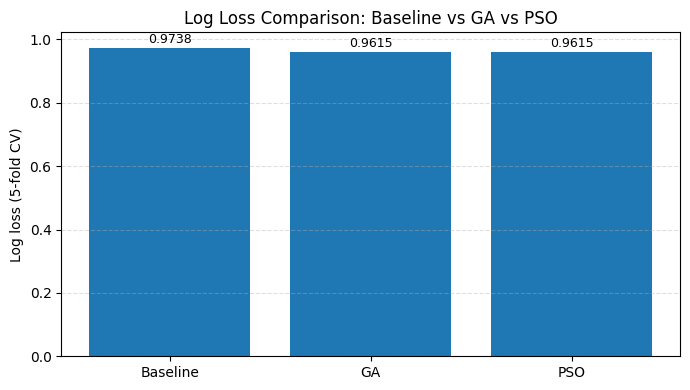

In [20]:
methods = ["Baseline", "GA", "PSO"]
log_losses = [baseline_log_loss, ga_log_loss, pso_log_loss]

plt.figure(figsize=(7,4))
bars = plt.bar(methods, log_losses)

for i, v in enumerate(log_losses):
    plt.text(i, v * 1.005, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

plt.ylabel("Log loss (5-fold CV)")
plt.title("Log Loss Comparison: Baseline vs GA vs PSO")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


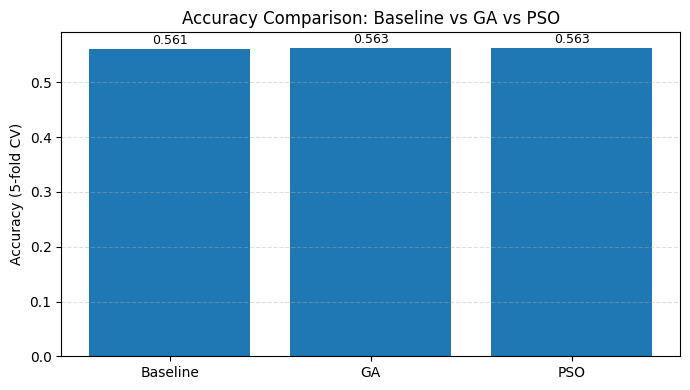

In [21]:
accuracies = [baseline_accuracy, ga_accuracy, pso_accuracy]

plt.figure(figsize=(7,4))
bars = plt.bar(methods, accuracies)

for i, v in enumerate(accuracies):
    plt.text(i, v * 1.005, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.ylabel("Accuracy (5-fold CV)")
plt.title("Accuracy Comparison: Baseline vs GA vs PSO")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


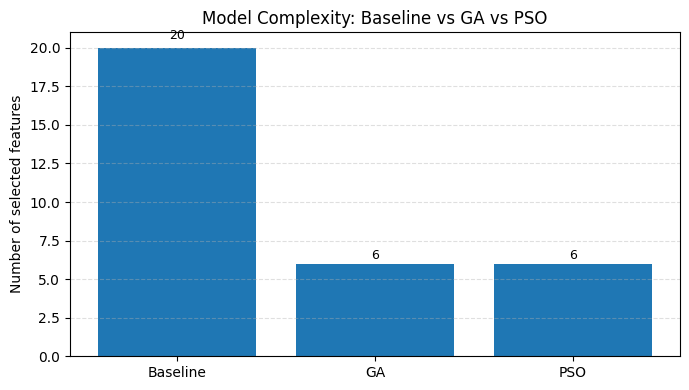

In [22]:
n_features_list = [
    len(baseline_cols),
    len(ga_cols),
    len(pso_cols),
]

plt.figure(figsize=(7,4))
bars = plt.bar(methods, n_features_list)

for i, v in enumerate(n_features_list):
    plt.text(i, v * 1.02, f"{v}", ha="center", va="bottom", fontsize=9)

plt.ylabel("Number of selected features")
plt.title("Model Complexity: Baseline vs GA vs PSO")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
